In [1]:
%matplotlib inline

In [2]:
import data_processor
import classification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="ticks", color_codes=True)

## Load data

In [3]:
df_2016 = data_processor.load_dataframe('data/data2016.mat')
df_2016['shoe'] = df_2016.label == 'shoe'
df_2017 = data_processor.load_dataframe('data/data2017.mat')
df_2017['shoe'] = df_2017.label == 'shoe'
df_2018 = data_processor.load_dataframe('data/data2018.mat')
df_2018['shoe'] = df_2018.label == 'shoe'

df_all = pd.concat((df_2016, df_2017, df_2018))

DATASETS = {"2016": df_2016, "2017": df_2017, "2018": df_2018, "all years merged": df_all}

## Visualization


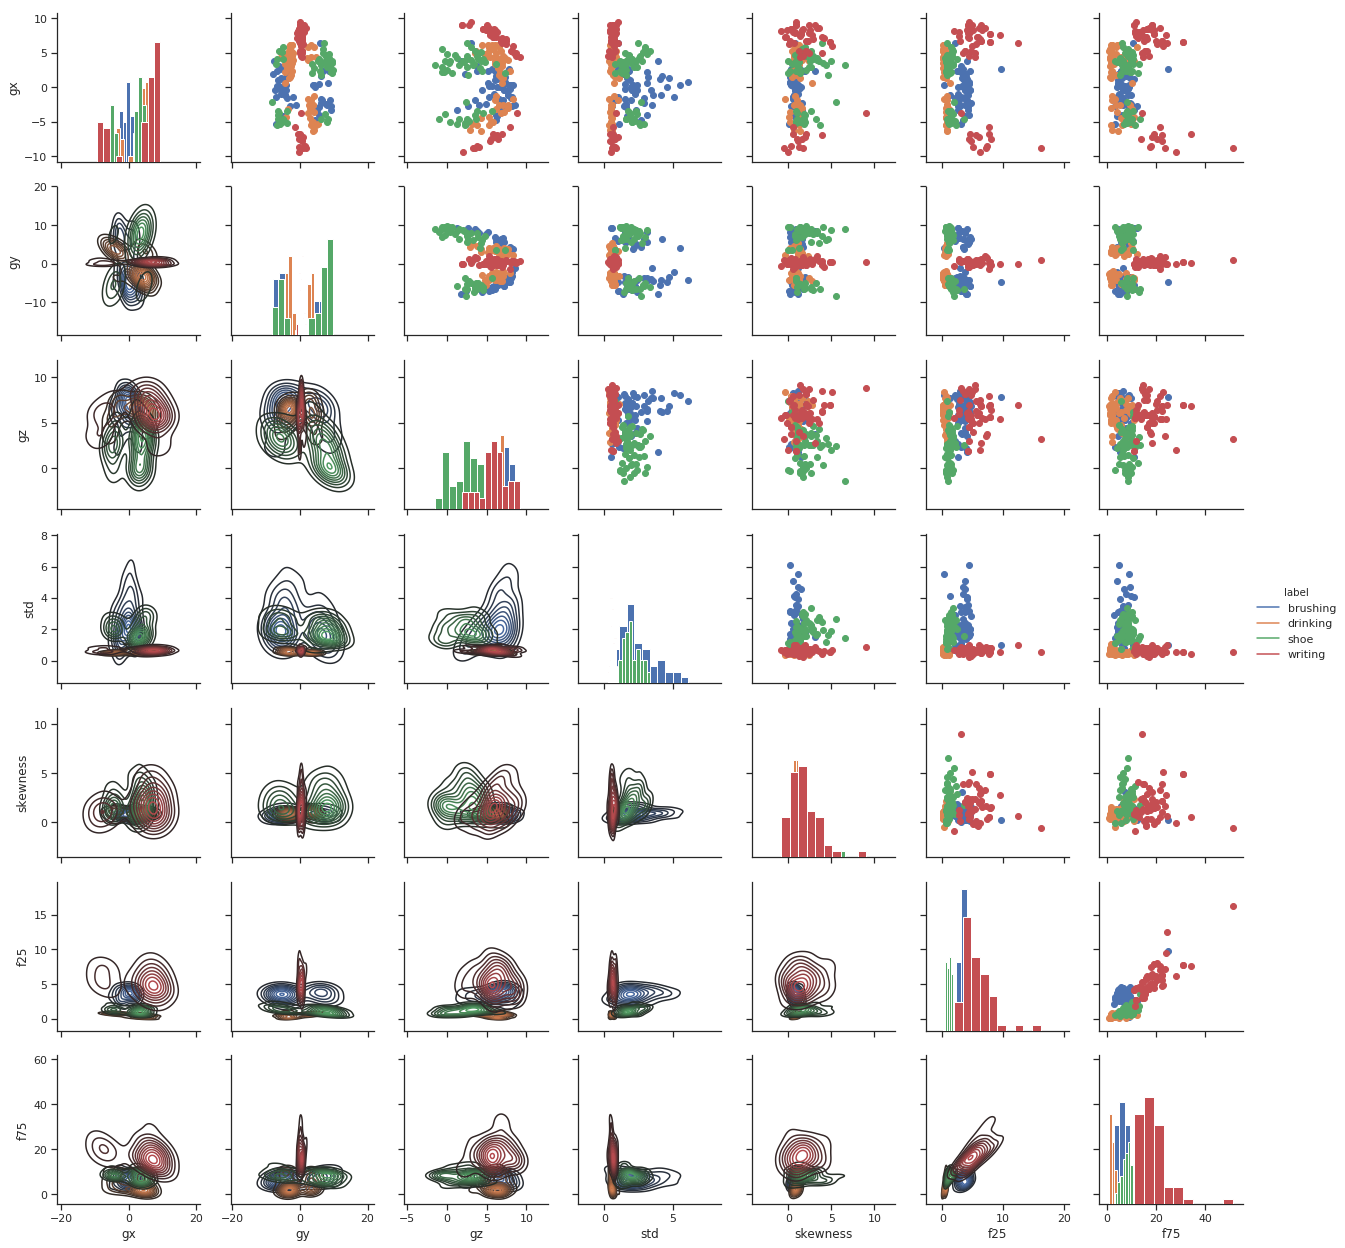

In [7]:
g = sns.PairGrid(df_all.drop("shoe", axis=1), hue="label")
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist)
g = g.add_legend()

## Machine learning...

Calculation SVM with rbf kernel for the data of 2016:
Accuracy: 0.876969696969697(+/- 0.17162754642649392)
Figure(720x504)
Calculation SVM with rbf kernel for the data of 2017:
Accuracy: 1.0(+/- 0.0)
Figure(720x504)
Calculation SVM with rbf kernel for the data of 2018:
Accuracy: 1.0(+/- 0.0)
Figure(720x504)
Calculation SVM with rbf kernel for the data of all years merged:
Accuracy: 0.9377777777777778(+/- 0.1205747552555603)
Figure(720x504)


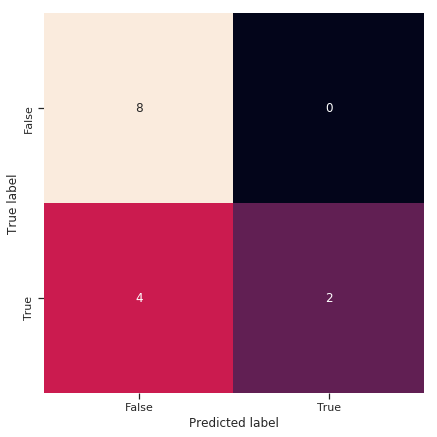

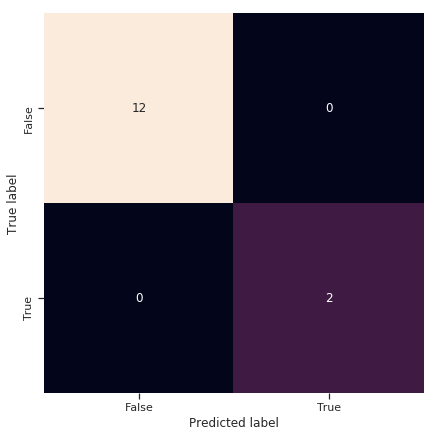

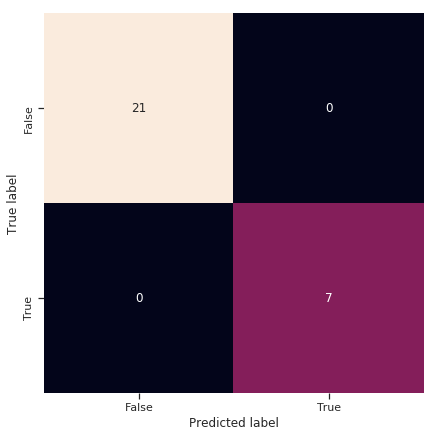

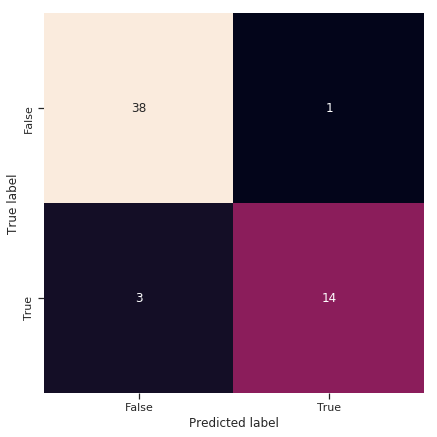

In [5]:
for name, dataset in DATASETS.items():
    print(f"Calculation SVM with rbf kernel for the data of {name}:")
    classification.cross_validation_svm(dataset.drop(["label", "shoe"], axis=1), dataset.shoe)
    classification.run_svm(dataset.drop(["label", "shoe"], axis=1), dataset.shoe)